<a href="https://colab.research.google.com/github/gracelcai/career-launch-group-13/blob/main/MediaPipe_computer_vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://raw.githubusercontent.com/googlesamples/mediapipe/main/examples/pose_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Pose_Landmarker.ipynb


# Setup

In [ ]:
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 21.7 MB/s eta 0:00:00


In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# Get Frame

In [ ]:
import cv2
video = cv2.VideoCapture('squat_17.mp4')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
print("Your video:\n")
mp4 = open('squat_17.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Your video:



In [ ]:
fps = video.get(cv2.CAP_PROP_FPS)
print('frame per seconds = ', fps)


frame per seconds =  25.0


your chosen frame


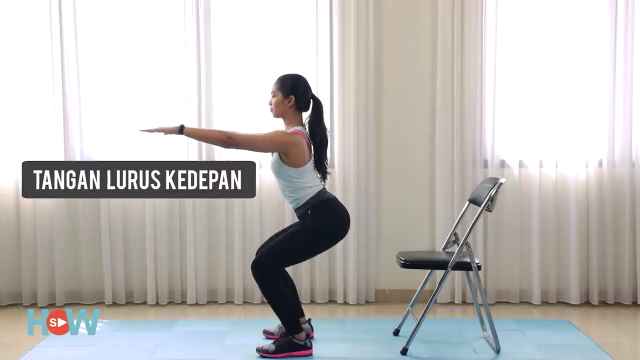

In [ ]:
#@markdown enter the frame you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
minutes = 0 # @param {type: "integer"}
seconds = 2 # @param {type: "integer"}

t_msec = 1000 * (minutes * 60 + seconds)
video.set(cv2.CAP_PROP_POS_MSEC, t_msec)
ret, frame = video.read()

frame = cv2.resize(frame, (0, 0), fx = 0.5, fy = 0.5)

print("your chosen frame")
cv2_imshow(frame)

In [ ]:
cv2.imwrite('frame.jpg', frame)

True

# Detecting Pose

Nose coordinates: (269.880313873291, 102.05147624015808)


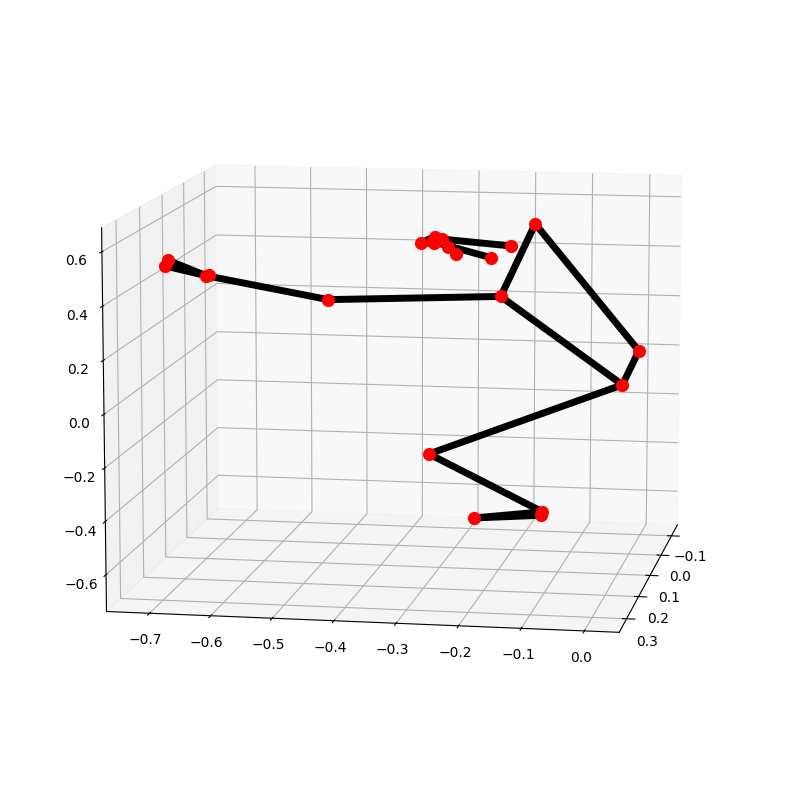

In [ ]:
# For static images:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  print(
      f'Nose coordinates: ('
      f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
      f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
  )

  annotated_image = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image = np.where(condition, annotated_image, bg_image)

  # Draw pose landmarks on the image.
  mp_drawing.draw_landmarks(
      annotated_image,
      results.pose_landmarks,
      mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image.jpg', annotated_image)
  # Plot pose world landmarks.
  mp_drawing.plot_landmarks(
      results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [ ]:
frame_hight, frame_width, _ = frame.shape
# Note: the times 100 might be wrong idk
x_coordinate = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * 100
y_coordinate = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * 100
z_coordinate = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].z * 100
print("x:", x_coordinate)
print("y:", y_coordinate)
print("z:", z_coordinate)

x: 42.16879904270172
y: 28.3476322889328
z: -11.91362589597702


# I don't think this part is necessary

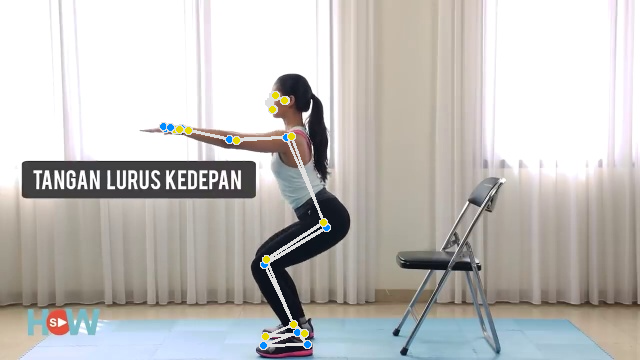

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

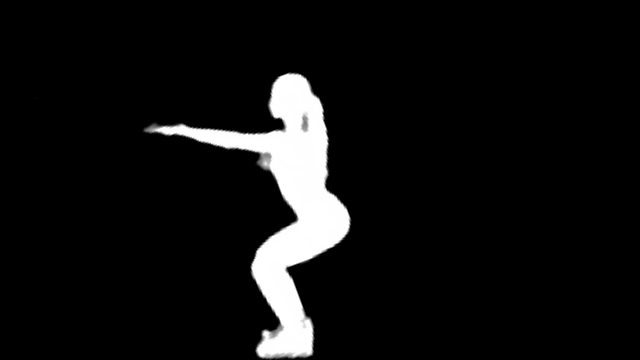

In [ ]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)

In [ ]:
import math
# Finding distance in specified axis (for different parts)
def xyz_distances(part_1, part_2, axis):
  if(axis == 'x'):
    return part_2.x - part_1.x
  elif(axis == 'y'):
    return part_2.y - part_1.y
  else:
    return part_2.z - part_1.z

# Finding distance in specified axis (for same part)
def landmarks(start_position, end_position, axis):
  if(axis == 'x'):
    return end_position.x - start_position.x
  elif(axis == 'y'):
    return end_position.y - start_position.y
  else:
    return end_position.z - start_position.z

# Finding 3D distances
def distance_3D(part_1, part_2):
  x = part_2.x - part_1.x
  y = part_2.y - part_1.y
  z = part_2.z - part_1.z
  return math.sqrt(x**2 + y**2 + z**2)

def angle(part_1, part_2, part_3):
  a_mag = math.sqrt((part_1.x - part_2.x)**2 + (part_1.y - part_2.y)**2 + (part_1.z - part_2.z)**2)
  b_mag = math.sqrt((part_3.x - part_2.x)**2 + (part_3.y - part_2.y)**2 + (part_3.z - part_2.z)**2)
  a_dot_b = ((part_1.x - part_2.x) * (part_3.x - part_2.x)) + ((part_1.y - part_2.y) * (part_3.y - part_2.y)) + ((part_1.z - part_2.z) * (part_3.z - part_2.z))
  angle = (math.acos(a_dot_b / (a_mag * b_mag))) * (180 / math.pi)
  return angle

def hip_midpoint_angle(left_hip, right_hip):


In [ ]:
part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_HIP]
part_1_end = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_HIP]

part_2_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_KNEE]
part_2_end = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_KNEE]

part_3_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_ANKLE]
part_3_end = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_ANKLE]

print("Right hip distance change:")
print("x distance:", xyz_distances(part_1_start, part_1_end, 'x'))
print("y distance:", xyz_distances(part_1_start, part_1_end, 'y'))
print("z distance:", xyz_distances(part_1_start, part_1_end, 'z'))

print("\nRight knee distance change:")
print("x distance:", xyz_distances(part_2_start, part_2_end, 'x'))
print("y distance:", xyz_distances(part_2_start, part_2_end, 'y'))
print("z distance:", xyz_distances(part_2_start, part_2_end, 'z'))

print("\nRight ankle distance change:")
print("x distance:", xyz_distances(part_3_start, part_3_end, 'x'))
print("y distance:", xyz_distances(part_3_start, part_3_end, 'y'))
print("z distance:", xyz_distances(part_3_start, part_3_end, 'z'))

print("\n\nRight Hip to Knee 3D Starting Distance")
print(distance_3D(part_1_start, part_2_start))

print("\nRight Hip to Knee 3D Ending Distance")
print(distance_3D(part_1_end, part_2_end))

print("\n\nRight Knee to Ankle 3D Starting Distance")
print(distance_3D(part_2_start, part_3_start))

print("\nRight Knee to Ankle 3D Ending Distance")
print(distance_3D(part_2_end, part_3_end))

print("\n\nHip-Knee-Ankle Starting Angle:", angle(part_1_start, part_2_start, part_3_start), "degrees")
print("\nHip-Knee-Ankle Ending Angle:", angle(part_1_end, part_2_end, part_3_end), "degrees")

print("\n\nNew midhip function stuff:")
right_knee = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_KNEE]
left_knee = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_KNEE]
right_hip = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_HIP]
left_hip = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_HIP]
print(mid_angle(right_knee, left_knee, right_hip, left_hip))

print("\n\nNew avg 3d function stuff:")
right_wrist = right_hip = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_WRIST]
right_ankle = right_hip = part_1_start = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_ANKLE]
print(distance_3D_avg(right_hip, right_wrist, right_ankle))